In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import pandas as pd
import numpy as np
import matplotlib
import threading
import matplotlib.pyplot as plt 
import seaborn as sns
from collections import Counter
matplotlib.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
import pickle
from sklearn import preprocessing
import time
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df

In [119]:
workingDirectory = '/home/h1bennet/lxr/results/180717_lxr_flx/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)
datadir = './tag_directories_rna/'

make hubs for ucsc

In [120]:
# %%bash
# makeMultiWigHub.pl hrb_lxrflx_kupffer_megahub mm10 -force -d /home/h1bennet/lxr/results/180717_lxr_flx/tag_directories_rna/* -color 255,127,0
# makeMultiWigHub.pl hrb_clec4fcre_lxrflx_kupffer_hub mm10 -force -d /home/h1bennet/lxr/results/180717_lxr_flx/tag_directories_rna/Clec* -color 106,61,154
# makeMultiWigHub.pl hrb_lysmcre_lxrflx_kupffer_hub mm10 -force -d /home/h1bennet/lxr/results/180717_lxr_flx/tag_directories_rna/Lys* -color 51,160,44

# QC

In [121]:
def ngs_qc(experiment, tag_dir):
    
    qc_dir = './qc_' + experiment
    # tag_dir = './tag_directories_' + experiment + '/'

    if not os.path.isdir(qc_dir):
        os.mkdir(qc_dir)
    
    # make summary table of qc stats
    qc_stats = pd.DataFrame()

    for sample in os.listdir(tag_dir + '/'):
        # pull tag information from HOMER output file
        if any(fname.endswith('tagInfo.txt') for fname in os.listdir(tag_dir+sample+'/')):
            tag_info_df = pd.read_table(tag_dir+sample+'/tagInfo.txt', sep='\t')
            qc_stats.loc[sample, 'uniquePositions'] = int(tag_info_df.iloc[0, 1])
            qc_stats.loc[sample, 'fragmentLengthEstimate'] = int(tag_info_df.iloc[1, 0].split('=')[1])
            qc_stats.loc[sample, 'tagsPerBP'] = float(tag_info_df.iloc[3, 0].split('=')[1])
            qc_stats.loc[sample, 'clonality'] = float(tag_info_df.iloc[4, 0].split('=')[1])
            qc_stats.loc[sample, 'GC_Content'] = float(tag_info_df.iloc[7, 0].split('=')[1])
        else:
            print(sample + ' had no aligned tags')
            qc_stats.loc[sample, 'uniquePositions'] = 0
            qc_stats.loc[sample, 'fragmentLengthEstimate'] = 0
            qc_stats.loc[sample, 'tagsPerBP'] = 0
            qc_stats.loc[sample, 'clonality'] = 0
            qc_stats.loc[sample, 'GC_Content'] = 0
        
        if experiment.lower() == 'rna':
            # pull star samples
            for file in os.listdir(tag_dir+sample+'/'):
                if file.endswith(".log"):
                    f = open(tag_dir+sample+'/'+file)
                    txt = f.read()
                    star_log = list(filter(None, re.split('\s|\|',txt)))
                    qc_stats.loc[sample, 'totalReads'] =int(star_log[29])
                    qc_stats.loc[sample, 'uniquelyMappedReads'] = int(star_log[41])
                    qc_stats.loc[sample, 'multiMappedReads'] = int(star_log[115])
                    qc_stats.loc[sample, 'frac_unmappedReads_mismatch'] = float(star_log[151].strip('%'))/100
                    qc_stats.loc[sample, 'frac_unmappedReads_short'] = float(star_log[158].strip('%'))/100
                    qc_stats.loc[sample, 'frac_unmappedReads_other'] = float(star_log[164].strip('%'))/100
                    qc_stats.loc[sample, 'uniquelyMappedFraction'] = \
                                                            qc_stats.loc[sample, 'uniquelyMappedReads'] \
                                                            / qc_stats.loc[sample, 'totalReads']
                    qc_stats.loc[sample, 'mappedFraction'] = 1 \
                                                    - qc_stats.loc[sample, 'frac_unmappedReads_other'] \
                                                    - qc_stats.loc[sample, 'frac_unmappedReads_short'] \
                                                    - qc_stats.loc[sample, 'totalReads']
        else:
            # pull bowtie samples
            for file in os.listdir(tag_dir+sample+'/'):
                if file.endswith(".log"):
                    f = open(tag_dir+sample+'/'+file)
                    bowtie_log = f.read().split()
                    qc_stats.loc[sample, 'totalReads'] = int(bowtie_log[0])
                    qc_stats.loc[sample, 'uniquelyMappedReads'] = int(bowtie_log[15])
                    qc_stats.loc[sample, 'multiMappedReads'] = int(bowtie_log[21])
                    qc_stats.loc[sample, 'unmappedReads'] = int(bowtie_log[10])
                    qc_stats.loc[sample, 'uniquelyMappedFraction'] = \
                                                                qc_stats.loc[sample, 'uniquelyMappedReads'] \
                                                                / qc_stats.loc[sample, 'totalReads']
                    qc_stats.loc[sample, 'mappedFraction'] = \
                                                        (qc_stats.loc[sample, 'totalReads'] \
                                                        - qc_stats.loc[sample, 'unmappedReads']) \
                                                        / qc_stats.loc[sample, 'totalReads']

                elif not any(fname.endswith('.log') for fname in os.listdir(tag_dir+sample+'/')):
                    print(sample + ' does not contain a mapping log file')
                    qc_stats.loc[sample, 'totalReads'] = 0
                    qc_stats.loc[sample, 'uniquelyMappedReads'] = 0
                    qc_stats.loc[sample, 'multiMappedReads'] = 0
                    qc_stats.loc[sample, 'frac_unmappedReads_mismatch'] = 0
                    qc_stats.loc[sample, 'frac_unmappedReads_short'] = 0
                    qc_stats.loc[sample, 'frac_unmappedReads_other'] = 0
                    qc_stats.loc[sample, 'uniquelyMappedFraction'] = 0
                    qc_stats.loc[sample, 'mappedFraction'] = 0
    
    qc_stats.sort_index(inplace=True)
    qc_stats.to_csv('./qc_' + experiment + '/mapping_stats.tsv', sep='\t')
    
    # make qc plots
    # clonality boxplot
    fig = sns.boxplot(y=qc_stats['clonality'].dropna()).get_figure()
    fig.savefig(qc_dir + '/clonality_boxplot_hb.pdf', bbox_inches='tight')
    fig.clf()
    # clonality distplot
    fig = sns.distplot(qc_stats['clonality'].dropna()).get_figure()
    fig.savefig(qc_dir + '/clonality_distplot_hb.pdf', bbox_inches='tight')
    fig.clf()
    # GC_Content boxplot
    fig = sns.boxplot(y=qc_stats['GC_Content'].dropna()).get_figure()
    fig.savefig(qc_dir + '/GC_Content_boxplot_hb.pdf', bbox_inches='tight')
    fig.clf()
    # mapped fraction boxplot
    fig = sns.boxplot(y=qc_stats['mappedFraction'].dropna()).get_figure()
    fig.savefig(qc_dir + '/mappedFraction_boxplot_hb.pdf', bbox_inches='tight')
    fig.clf()
    # mapped fraction distplot
    fig = sns.distplot(qc_stats['mappedFraction'].dropna()).get_figure()
    fig.savefig(qc_dir + '/mappedFraction_distplot_hb.pdf', bbox_inches='tight')
    fig.clf()
    # uniquely Mapped Fraction boxplot
    fig = sns.boxplot(y=qc_stats['uniquelyMappedFraction'].dropna()).get_figure()
    fig.savefig(qc_dir + '/uniquelyMappedFraction_boxplot_hb.pdf', bbox_inches='tight')
    fig.clf()
    # uniquely Mapped Fraction distplot
    fig = sns.distplot(qc_stats['uniquelyMappedFraction'].dropna()).get_figure()
    fig.savefig(qc_dir + '/uniquelyMappedFraction_distplot_hb.pdf', bbox_inches='tight')
    fig.clf()
    # uniquely Mapped Reads boxplot
    fig = sns.boxplot(y=qc_stats['uniquelyMappedReads'].dropna()).get_figure()
    fig.savefig(qc_dir + '/uniquelyMappedReads_distplot_hb.pdf', bbox_inches='tight')
    fig.clf()
    # uniquely Mapped Reads distplot
    fig = sns.distplot(qc_stats['uniquelyMappedReads'].dropna()).get_figure()
    fig.savefig(qc_dir + '/uniquelyMappedReads_distplot_hb.pdf', bbox_inches='tight')
    fig.clf()
    
    return qc_stats

def label_point(x, y, val, ax, fontsize=12):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        # print(i, point)
        ax.text(point['x']+.02,
                point['y'],
                str(point['val']),
                fontsize=fontsize)

def quantile_normalize_df(df_input):
    df = df_input.copy()
    #compute rank
    dic = {}
    for col in df:
        dic.update({col : sorted(df[col])})
    sorted_df = pd.DataFrame(dic)
    rank = sorted_df.mean(axis = 1).tolist()
    #sort
    for col in df:
        t = np.searchsorted(np.sort(df[col]), df[col])
        df[col] = [rank[i] for i in t]
    return df

In [122]:
rna_qc = ngs_qc('rna', datadir)

/home/h1bennet/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


In [123]:
# %%bash
# # if directories don't exist, create them
# if [ ! -d ./expression/ ]; then mkdir ./expression; fi

# analyzeRepeats.pl rna mm10 -count exons -condenseGenes -raw -d ./tag_directories_rna/* > ./expression/rna_exp_raw.tsv
# analyzeRepeats.pl rna mm10 -count exons -condenseGenes -d ./tag_directories_rna/* > ./expression/rna_exp.tsv
# analyzeRepeats.pl rna mm10 -count exons -condenseGenes -rpkm -d ./tag_directories_rna/* > ./expression/rna_exp_rpkm.tsv

In [124]:
# %%bash
# source activate edger
# getDiffExpression.pl ./expression/rna_exp_raw.tsv control control c_ahet_bko_tim4neg c_ahet_bko_tim4pos c_ako_bhet_tim4neg c_ako_bhet_tim4pos lxrako lxrako lxrdko lxrdko l_ako_bhet_tim4neg l_ako_bhet_tim4pos l_lxrdko_tim4pos l_lxrdko_tim4pos l_lxrdko_tim4pos -edgeR -simpleNorm -dispersion 0.05 > ./expression/diff_output.txt

In [125]:
# %%bash
# source activate deseq
# getDiffExpression.pl ./expression/rna_exp_raw.tsv control control dump dump dump dump dump dump lxrdko lxrdko dump dump l_lxrdko_tim4pos l_lxrdko_tim4pos l_lxrdko_tim4pos -AvsA > ./expression/diff_output_dump.txt

In [126]:
# read in rpkm
rpkm = pd.read_csv('./expression/rna_exp_rpkm.tsv', sep='\t')
rpkm.set_index(rpkm.columns.values[0], inplace=True)
rpkm.index.rename('refseqID', inplace=True)
# set rpkm index
mm10_gene = rpkm['Annotation/Divergence'].str.split('|').str[0]

# clean up column names
# rename rpkm columns
rpkm = rpkm.rename(columns=dict(zip(rpkm.iloc[:, 7:].columns.values,
                                    pd.Series(rpkm.iloc[:, 7:].columns.values).str[:-5].str.split('/').str[-1])))
# change index to gene names
rpkm['gene'] = mm10_gene
rpkm = rpkm.reset_index().set_index('gene').drop(labels='refseqID', axis=1)

# filter genes with length < 250 bp
rpkm = rpkm.loc[rpkm.Length >= 250, :]

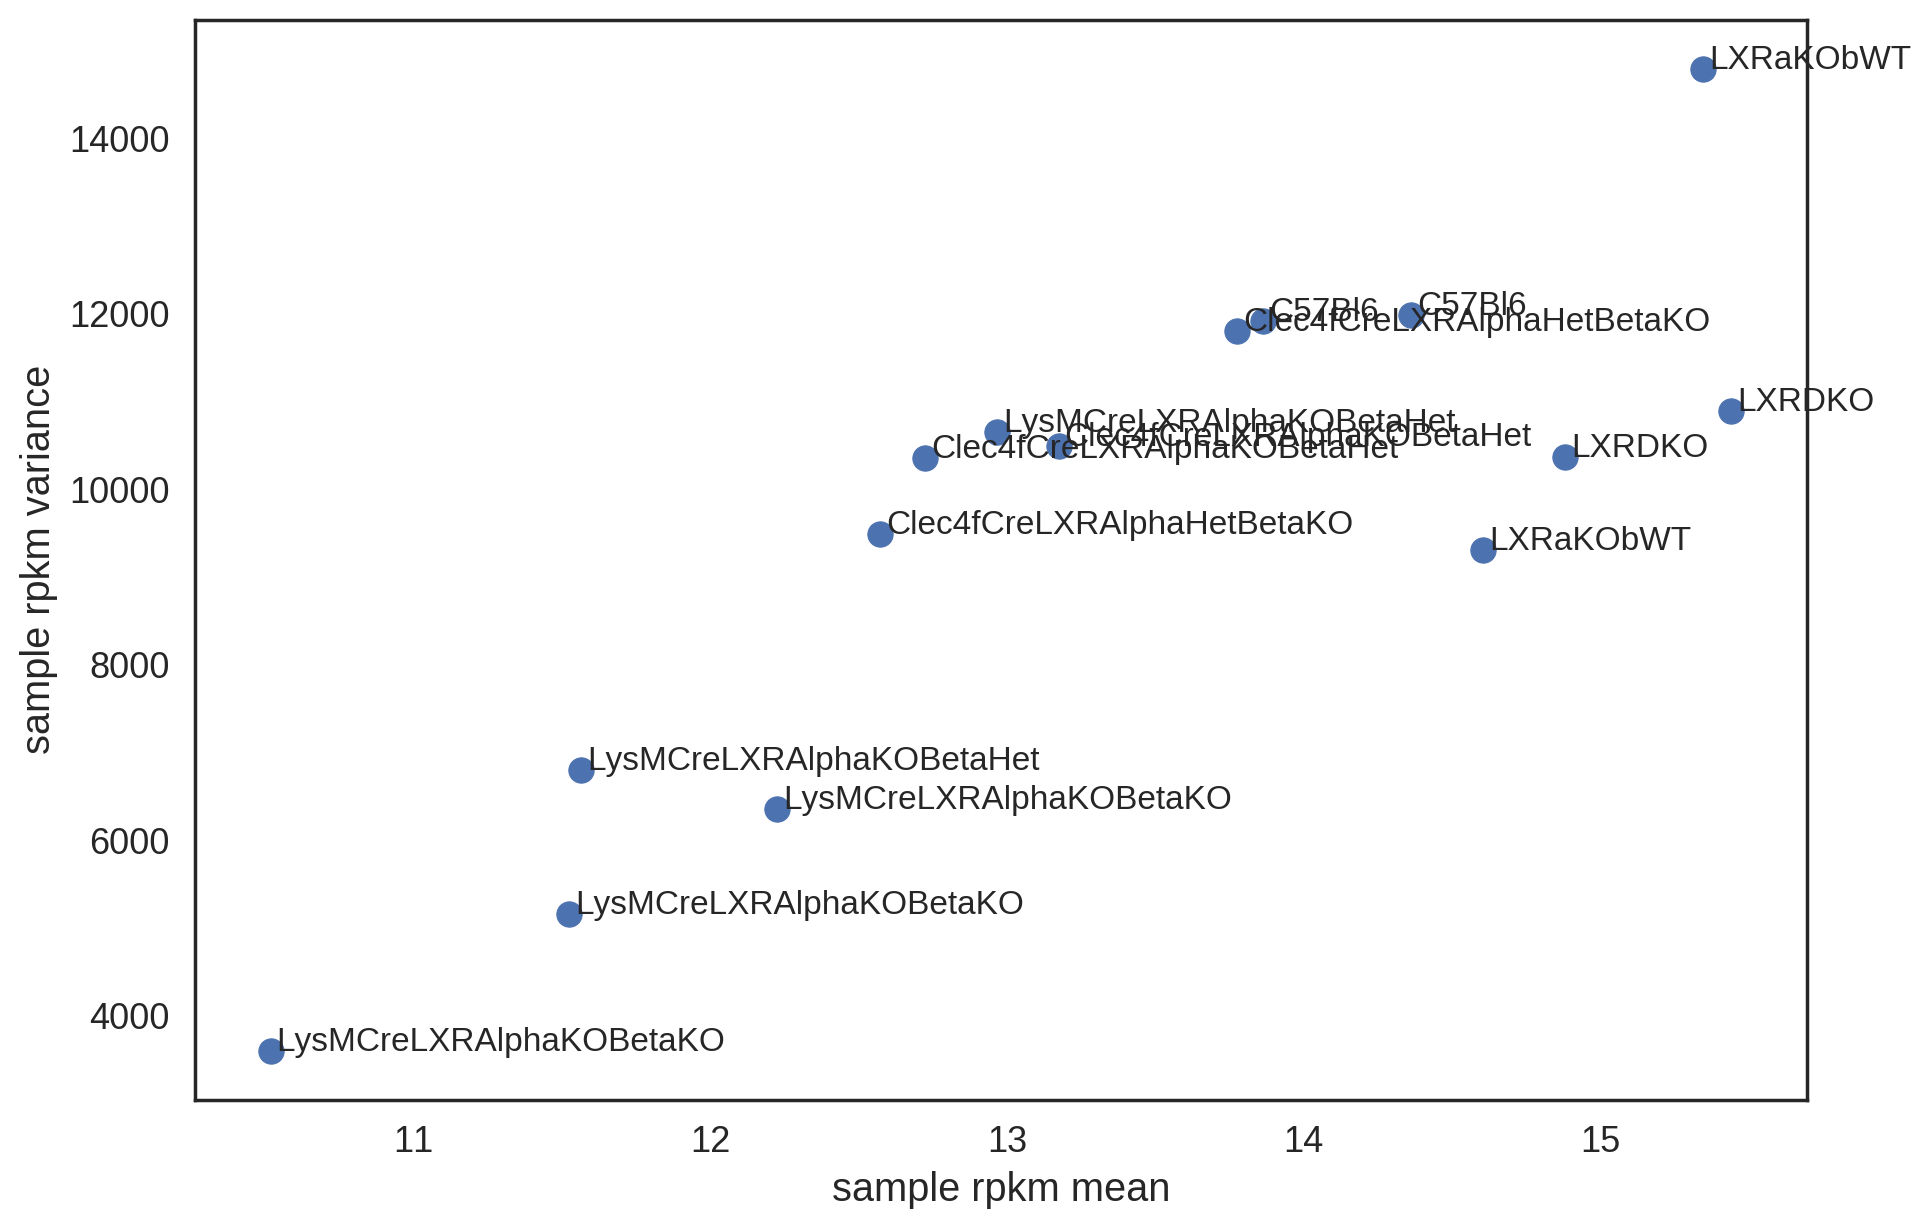

In [127]:
ax = plt.scatter(rpkm.iloc[:, 7:].mean(), rpkm.iloc[:, 7:].var())
plt.xlabel('sample rpkm mean')
plt.ylabel('sample rpkm variance')
label_point(rpkm.iloc[:, 7:].mean(),
            rpkm.iloc[:, 7:].var(),
            pd.Series(rpkm.iloc[:, 7:].columns.values, index=rpkm.iloc[:, 7:].columns.values).str.split('_').str[0],
            plt.gca())

In [128]:
# import differential gene expression
diff_gene = pd.read_csv('./expression/diff_output_dump.txt', sep='\t', index_col=0)
diff_gene.index.rename('RepeatID', inplace=True)
mm10_gene = diff_gene['Annotation/Divergence'].str.split('|').str[0]

# create gene name index
diff_gene['gene'] = mm10_gene
diff_gene = diff_gene.reset_index().set_index('gene').drop(labels='RepeatID', axis=1)

# filter entries without a gene
# diff_gene = diff_gene.loc[diff_gene.index.notna(), :]
print(diff_gene.shape)

(24537, 40)


In [129]:
def pull_comparision(diff_gene, comp):
    return diff_gene.loc[:, [comp + ' Log2 Fold Change',
                            comp + ' p-value',
                            comp + ' adj. p-value']]

# extract groups
comp_dict = {}
pattern='(\w* vs. \w*).*'
for col in diff_gene.columns.values:
    m = re.search(string=col, pattern=pattern)
    if m:
        df = pull_comparision(diff_gene, m.group(1))
        df.columns = ['log2fc', 'pval', 'adj_pval']
        comp_dict[re.sub('G0[0-9]_', '', m.group(1))] = df

In [130]:
#### Write gene list for analysis with metascape
pval = 0.01 # p value cutoff
fc = 1 # fc cutoff for interesting genes
fc_max = 1.3 # max fc to define as unchanged

In [131]:
llxr_dko_up = ((comp_dict['control vs. l_lxrdko_tim4pos'].adj_pval <= pval) & \
    (comp_dict['control vs. l_lxrdko_tim4pos'].log2fc >= fc))

llxr_dko_dn = ((comp_dict['control vs. l_lxrdko_tim4pos'].adj_pval <= pval) & \
    (comp_dict['control vs. l_lxrdko_tim4pos'].log2fc <= -fc))

In [132]:
# Import packages for PCA analysis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA # uses SVD

In [133]:
if not os.path.isdir('./figures'):
    os.mkdir('./figures')

In [134]:
samples = pd.Series(rpkm.iloc[:, 7:].columns.values)
cage = samples.str.split('_').str[-1]
group = ['_'.join(i) for i in samples.str.split('_').str[:-1]]
gender = samples.str.split('_').str[1]

samplesDF = pd.DataFrame([pd.Series(samples),
                          pd.Series(cage),
                          pd.Series(group),
                          pd.Series(gender)],
                          index=['sample', 'cage', 'group', 'gender']).T

In [135]:
samplesDF.loc[:, 'genotype'] = ['wt', 'wt',
                         'c_aHetbKO_neg',
                         'c_aHetBKO_pos',
                         'c_aKObHet_neg',
                         'c_aKObHet_pos',
                         'wb_aKObWT',
                         'wb_aKObWT',
                         'wb_DKO',
                         'wb_DKO',
                         'L_aKObHet_neg',
                         'L_aKObHet_pos',
                         'L_DKO_pos',
                         'L_DKO_pos',
                         'L_DKO_pos']
samplesDF.loc[:, 'genotype_gender'] = samplesDF.genotype + '_' + samplesDF.gender

In [136]:
rpkm_filt = rpkm.loc[(rpkm.iloc[:, 7:] > 4).all(1), :]
# standardize matrix, mean=0, std=1
tpm_std = StandardScaler().fit_transform(rpkm_filt.iloc[:, 7:])
# run PCA
pca = PCA(n_components=3)
tpm_pca = pca.fit_transform(tpm_std.T)
exp_var = pca.explained_variance_ratio_
#create df for plotting
tpm_pca_df = pd.DataFrame(tpm_pca, columns=['PC1', 'PC2', 'PC3'],
        index=(samplesDF.loc[:, 'genotype_gender'])).reset_index()
tpm_pca_df['cage'] = samplesDF['cage']

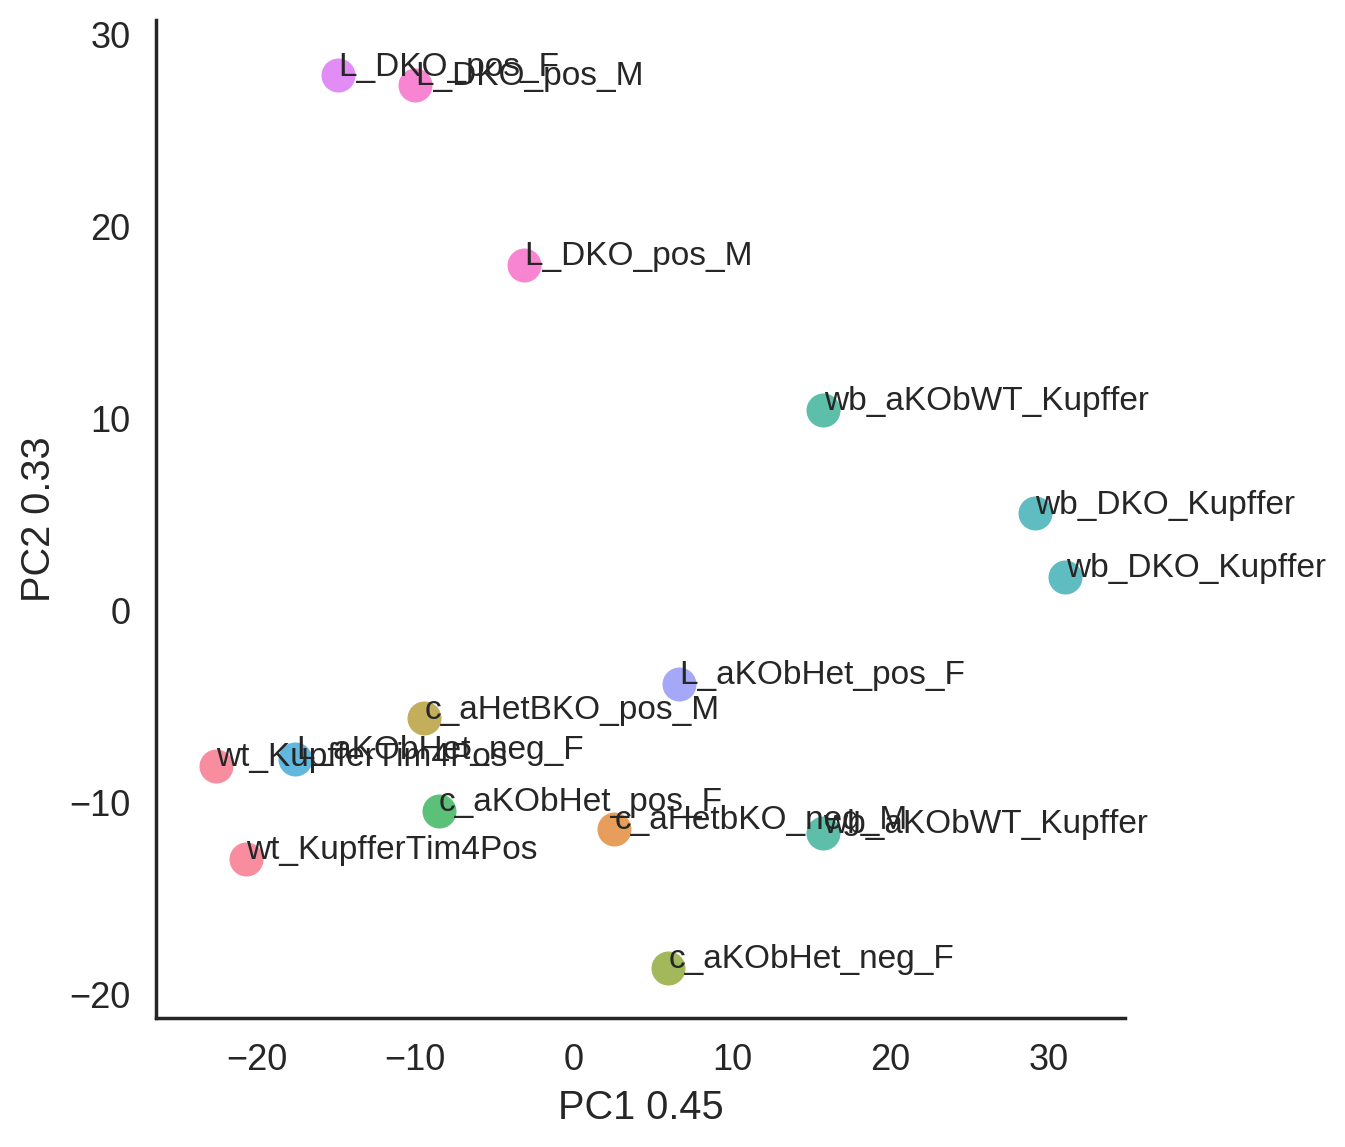

In [137]:
ax = sns.lmplot('PC1', 'PC2', tpm_pca_df, fit_reg=False,
                hue='genotype_gender', # palette=color_dict,
                size=6, scatter_kws={'s': 150},
                legend=False)
ax.set(xlabel=('PC1 %.2f' % exp_var[0]), ylabel=('PC2 %.2f' % exp_var[1]))
label_point(tpm_pca_df.PC1,
            tpm_pca_df.PC2,
            tpm_pca_df.genotype_gender,
            plt.gca(),
            fontsize=12)
plt.savefig('./figures/rna_pca.pdf')

In [138]:
transcript_pc = pd.DataFrame(pca.components_.T, rpkm_filt.index, columns=['PC1','PC2','PC3'])

In [139]:
transcript_pc.sort_values('PC1', ascending=False).head()

,PC1,PC2,PC3
gene,,,
Cd74,0.452488,-0.313090,-0.445335
H2-Aa,0.223665,-0.124364,-0.188910
Actb,0.209707,0.328669,0.206825
H2-Ab1,0.167527,-0.106285,-0.129651
H2-Eb1,0.141246,-0.081940,-0.104290


In [140]:
#### Write gene list for analysis with metascape
pval = 0.01 # p value cutoff
fc = 1 # fc cutoff for interesting genes
fc_max = 1.3 # max fc to define as unchanged
up_down_dict = {}

for key, diff in comp_dict.items():
    
    up = ( comp_dict[key].adj_pval <= pval ) & \
    ( comp_dict[key].log2fc >= fc )
    
    dn = ( comp_dict[key].adj_pval <= pval ) & \
    ( comp_dict[key].log2fc <= -fc )
    
    with open('./expression/'+key+'_up_fc2_p01.txt', 'w') as f:
        f.write('gene\n')
        for val in up[up].index.values:
            f.write(val+'\n')
        f.close()

    with open('./expression/'+key+'_dn_fc2_p01.txt', 'w') as f:
        f.write('gene\n')
        for val in dn[dn].index.values:
            f.write(val+'\n')
        f.close()
        
    up_down_dict[key[12:]] = ( len(dn[dn].index.values),
                               len(up[up].index.values) )
        
    sns.clustermap(
        rpkm.loc[rpkm.index.isin(up[up].index.values), :].iloc[:, 7:],
        z_score=0,
        cmap='RdBu_r',
        col_cluster=False)
    plt.savefig('./figures/'+key+'_up_fc2_p01_heatmap.pdf')
    plt.close()
    
    sns.clustermap(
        rpkm.loc[rpkm.index.isin(dn[dn].index.values), :].iloc[:, 7:],
        z_score=0,
        cmap='RdBu_r',
        col_cluster=False)
    plt.savefig('./figures/'+key+'_dn_fc2_p01_heatmap.pdf')
    plt.close()

/home/h1bennet/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [141]:
pd.DataFrame(up_down_dict, index=['downreg', 'upreg']).T

,downreg,upreg
_lxrdko_tim4pos,2470,1566
dko,341,172
dump,19,210
l_lxrdko_tim4pos,637,639
lxrdko,776,1972
xrdko_tim4pos,194,49


In [142]:
# llxr_dko_pos_dn = [line.strip() for line in open('./expression/l_lxrdko_tim4pos_dn_fc2_p01.txt', 'r').readlines()][1:]
# nash_20wk_pos_dn = [line.strip() for line in open('/home/h1bennet/liverStrains/results/180517_RNASeq_NASH_Timecourse/expression/tim4pos_20wk_dn_fc2_p01.txt', 'r').readlines()]
# nash_20wk_pos_up = [line.strip() for line in open('/home/h1bennet/liverStrains/results/180517_RNASeq_NASH_Timecourse/expression/tim4pos_20wk_up_fc2_p01.txt', 'r').readlines()]
# nash_10wk_pos_dn = [line.strip() for line in open('/home/h1bennet/liverStrains/results/180517_RNASeq_NASH_Timecourse/expression/tim4pos_10wk_dn_fc2_p01.txt', 'r').readlines()]
# nash_10wk_pos_up = [line.strip() for line in open('/home/h1bennet/liverStrains/results/180517_RNASeq_NASH_Timecourse/expression/tim4pos_10wk_up_fc2_p01.txt', 'r').readlines()]

In [143]:
lysm_dko = comp_dict['control vs. l_lxrdko_tim4pos']
lysm_dko.sort_values('adj_pval')[:60]

,log2fc,pval,adj_pval
gene,,,
Fosb,7.599483,1.276741e-278,1.851274e-274
Cxcl2,6.563088,5.647693e-168,4.094577e-164
Pim1,3.749352,2.645774e-152,1.278791e-148
Arsb,3.319809,2.306155e-117,8.359814e-114
Ier5,2.718089,4.972669e-98,1.442074e-94
Ppp1r15a,3.744794,1.059193e-96,2.559716e-93
Ccr3,3.123877,3.547613e-95,7.348627e-92
Tnfaip3,3.605098,1.207269e-92,2.188175e-89
Sort1,5.159156,8.934083e-91,1.439380e-87


In [144]:
comp_dict.keys()

dict_keys(['control vs. dump', 'control vs. lxrdko', 'control vs. l_lxrdko_tim4pos', 'dump vs. lxrdko', 'dump vs. l_lxrdko_tim4pos', 'lxrdko vs. l_lxrdko_tim4pos'])

In [145]:
lysmdko_wbdko = comp_dict['lxrdko vs. l_lxrdko_tim4pos']
lysmdko_wbdko.sort_values('adj_pval')[:60]

,log2fc,pval,adj_pval
gene,,,
Cd5l,7.131433,0.000000e+00,0.000000e+00
Timd4,6.896938,0.000000e+00,0.000000e+00
Fosb,8.516913,0.000000e+00,0.000000e+00
Abca1,4.764947,1.990922e-276,7.903464e-273
Vsig4,4.632160,6.615852e-249,2.101062e-245
Cxcl2,7.208663,2.185026e-235,5.782671e-232
Slc45a3,4.315042,8.624235e-210,1.956346e-206
Cd163,5.607140,1.829690e-205,3.631705e-202
Hbegf,4.843150,2.559527e-172,4.515860e-169


Create RPKM Matrix for plotting average gene expression

In [146]:
rpkm_mat = rpkm.iloc[:, 7:]

In [147]:
gene = 'Abca1'
avg = [rpkm_mat.iloc[:, 0:2].loc[gene, :].mean(),
       rpkm_mat.iloc[:, 6:8].loc[gene, :].mean(),
       rpkm_mat.iloc[:, 8:10].loc[gene, :].mean(),
       rpkm_mat.iloc[:, -2:].loc[gene, :].mean()]
std = [rpkm_mat.iloc[:, 0:2].loc[gene, :].std(),
       rpkm_mat.iloc[:, 6:8].loc[gene, :].std(),
       rpkm_mat.iloc[:, 8:10].loc[gene, :].std(),
       rpkm_mat.iloc[:, -2:].loc[gene, :].std()]

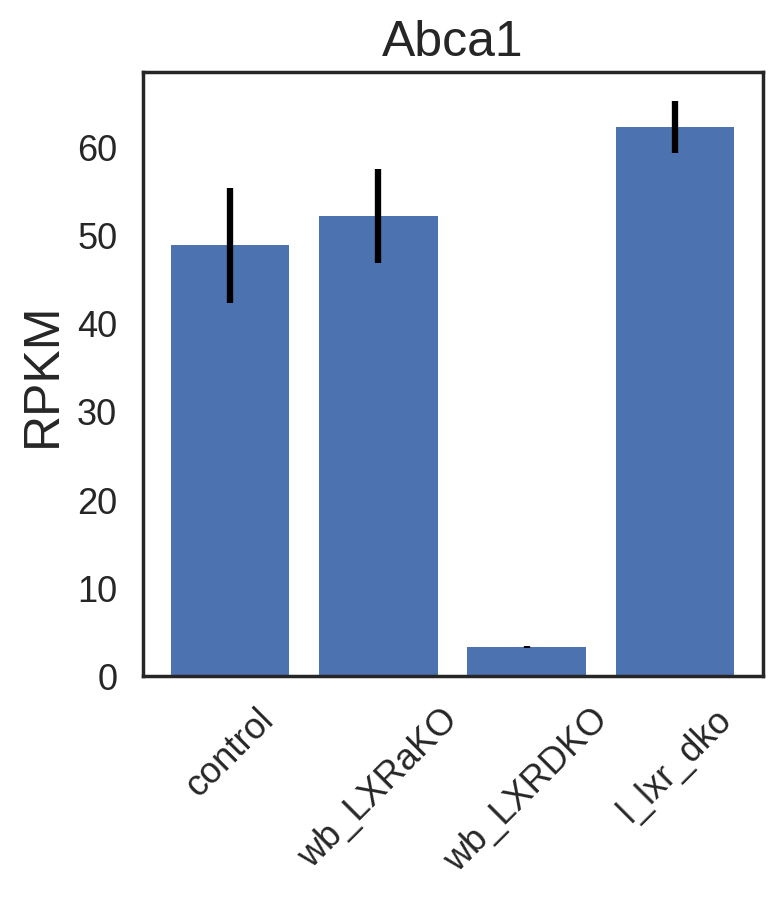

In [148]:
fig, ax = plt.subplots(figsize=(4,4))
ind = np.arange(len(avg))
fig = plt.bar(ind, avg)
plt.errorbar(ind, avg, yerr=std, fmt='none', ecolor='k')
plt.ylabel('RPKM', fontsize=18)
plt.xticks(ind,
           ['control', 'wb_LXRaKO', 'wb_LXRDKO', 'l_lxr_dko'],
           rotation=45)
plt.title(gene, fontsize=18)


# Check Flavo Response
___
Jason has some prelim data that suggests the effect we are seeing could be due to the difference in flavopirodol treatment

In [149]:
# import flavopiridol getDiff file
flavo_diff = pd.read_csv('../../data/getDiff_Flavo_noFlavo.txt', sep='\t', index_col=0)
flavo_diff.index.rename('RepeatID', inplace=True)
flavo_diff['gene'] = mm10_gene
flavo_diff = flavo_diff.reset_index().set_index('gene').drop(labels='RepeatID', axis=1)

In [203]:
# import other gene lists for comparison
with open('/home/h1bennet/lxr/data/kc_signature_lavin_amit.txt', 'r') as f:
    kc_amit = [gene.strip().strip('\"') for gene in f.readlines()]
    
# scott clec4f-cre x lxra flx/flx mice data
# group1 = cre+ lxr deleted
# group2 = cre- lxr positive
scott_de = pd.read_csv('/home/h1bennet/lxr/data/scott_kupffer_de_genes.txt', sep='\t', skiprows=1)
scott_clec_lxrko_dn = scott_de.Group_1_dn.tolist()
scott_clec_lxrko_up = scott_de.Group_1_up.tolist()
scott_clec_lxrwt_up = scott_de['Group 0_up'].tolist()
scott_clec_lxrwt_dn = scott_de.Group_0_dn.tolist()

In [151]:
# pull our comparisons of interest
lxrdko_lysmdko = comp_dict['lxrdko vs. l_lxrdko_tim4pos']

# pull some dummy comparisons
lxrdko = comp_dict['control vs. lxrdko']
dump = comp_dict['control vs. dump']

Check whether p < 0.05 there is significant overlap in significant genes

In [334]:
def get_diff_hypergeom_test(df, df2, pval=0.05, fc = 0):
    '''Takes two pandas dataframes in the get diff format
    last three cols fc, pval, adj_p and returns a gene overlap
    for them at a given p value and fc, need same index'''
    from scipy.stats import hypergeom
    # get gene lists
    df_sig = [df.loc[(df.iloc[:, -3] >= fc) & (df.iloc[:, -1] <= pval), :].index.tolist(),
               df.loc[(df.iloc[:, -3] <= -fc) & (df.iloc[:, -1] <= pval), :].index.tolist()]
    
    df2_sig = [df2.loc[(df2.iloc[:, -3] >= fc) & (df2.iloc[:, -1] <= pval), :].index.tolist(),
               df2.loc[(df2.iloc[:, -3] <= -fc) & (df2.iloc[:, -1] <= pval), :].index.tolist()]
    p = []
    fig, axs = plt.subplots(1, 2, figsize=(10,10))
    overlap=[]
    for i, test in [(0, 'up'), (1, 'down')]:
        # run hypergeom test
        M = df.shape[0] # rows = total genes
        n = len(df_sig[i]) # number of sig genes group 1
        N = len(df2_sig[i]) # number of sig genes in group 2
        x = len(set(df_sig[i]).intersection(df2_sig[i]))
        hypergeo = hypergeom(M, n, N)
        p.append(hypergeo.pmf(x))
        overlap.append(set(df_sig[i]).intersection(df2_sig[i]))
        print('working on', test, 'genes')
        print('total genes:', M)
        print('df sig genes:', n)
        print('df2 sig genes:', N)
        print('overlap:', x)
        print('hypergeometric p value:', p[i])
        matplotlib_venn.venn2([set(df_sig[i]), set(df2_sig[i])],
                              set_labels=['df1_genes', 'df2_genes'],
                              ax=axs[i])
        axs[i].set_title('genes '+test+', fc > '+str(2**fc)+', p < '+str(pval))
    return (p, overlap)

def get_diff_hypergeom_test_list(df, input_list, pval=0.05, fc=0):
    '''Takes two pandas dataframes in the get diff format
    last three cols fc, pval, adj_p and returns a gene overlap
    for them at a given p value and fc, need same index'''
    from scipy.stats import hypergeom
    import matplotlib_venn
    # get gene lists
    df_sig = [df.loc[(df.iloc[:, -3] >= fc) & (df.iloc[:, -1] <= pval), :].index.tolist(),
               df.loc[(df.iloc[:, -3] <= -fc) & (df.iloc[:, -1] <= pval), :].index.tolist()]
    
    p = []
    overlap=[]
    fig, axs = plt.subplots(1, 2, figsize=(10,10))
    for i, test in [(0, 'up'), (1, 'down')]:
        # run hypergeom test
        M = df.shape[0] # rows = total genes
        n = len(df_sig[i]) # number of sig genes group 1
        N = len(input_list) # number of sig genes in group 2
        x = len(set(df_sig[i]).intersection(input_list))
        hypergeo = hypergeom(M, n, N)
        p.append(hypergeo.pmf(x))
        overlap.append(set(df_sig[i]).intersection(input_list))
        print('working on', test, 'genes')
        print('total genes:', M)
        print('df sig genes:', n)
        print('input list sig genes:', N)
        print('overlap:', x)
        print('hypergeometric p value:', p[i])
        matplotlib_venn.venn2([set(df_sig[i]), set(input_list)],
                              set_labels=['df_genes', 'list_genes'],
                              ax=axs[i])
        axs[i].set_title('genes '+test+', fc > '+str(2**fc)+', p < '+str(pval))
    return (p, overlap)

# How similar are the Lysm-Cre x LXRa/b fl/fl to LXR DKO?

working on up genes
total genes: 24537
df sig genes: 639
df2 sig genes: 1972
overlap: 203
hypergeometric p value: 9.98658226765e-70
working on down genes
total genes: 24537
df sig genes: 637
df2 sig genes: 776
overlap: 125
hypergeometric p value: 3.58163828163e-63


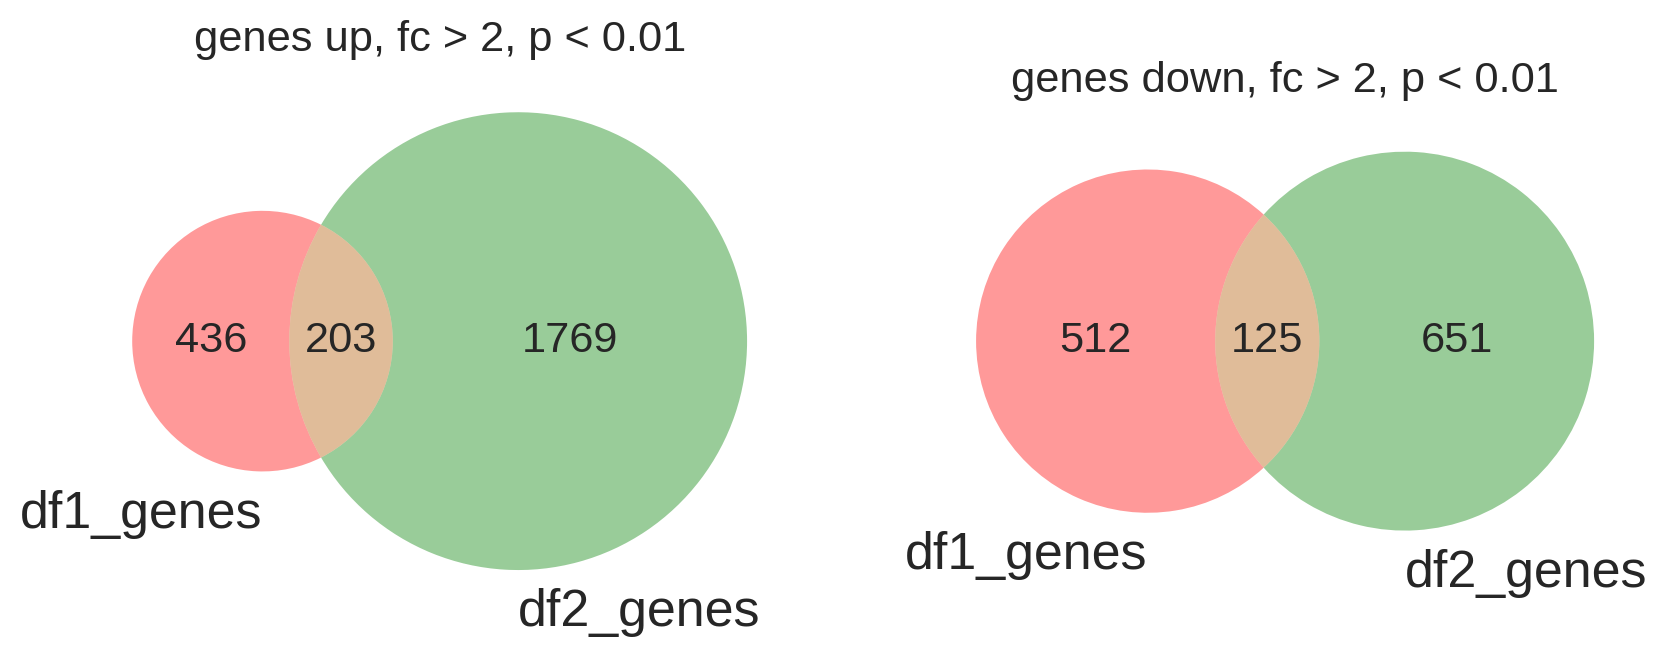

In [335]:
hypergeo_p, overlap = get_diff_hypergeom_test(lysm_dko, lxrdko, pval = 0.01, fc=1)

In [336]:
print( ((lxrdko_lysmdko['adj_pval'] <= 0.05) & (lxrdko_lysmdko['log2fc'] > 0)).value_counts())
print( ((lxrdko_lysmdko['adj_pval'] <= 0.05) & (lxrdko_lysmdko['log2fc'] < 0)).value_counts())


False    20751
True      3786
dtype: int64
False    20467
True      4070
dtype: int64


while there are significant genes with overlap between the lxrdko and lysmcre lxr flx/flx there are also significant differences (almost 8k diff genes at p < 0.05) between the two groups, likely in part due to the fact that the liver also changes dramatically with the whole body lxr knockout

## Test overlap between lysmdko and the flavopiridol genes

working on up genes
total genes: 24537
df sig genes: 2390
df2 sig genes: 738
overlap: 314
hypergeometric p value: 2.21916341753e-126
working on down genes
total genes: 24537
df sig genes: 2001
df2 sig genes: 741
overlap: 177
hypergeometric p value: 1.88954841051e-40


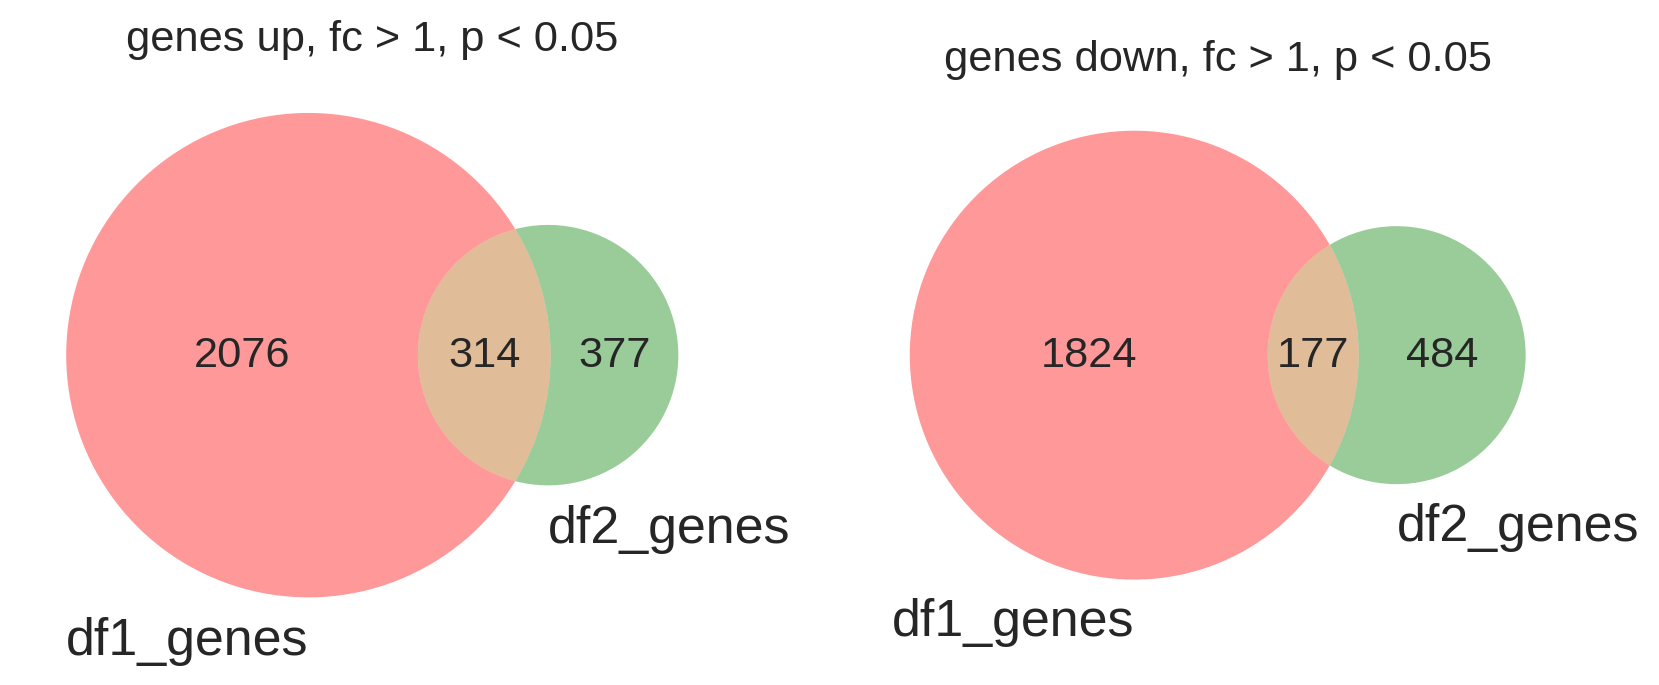

In [337]:
hypergeo_p, overlap = get_diff_hypergeom_test(lysm_dko, flavo_diff, pval = 0.05, fc=0)

working on up genes
total genes: 24537
df sig genes: 2858
df2 sig genes: 738
overlap: 105
hypergeometric p value: 0.00419103092522
working on down genes
total genes: 24537
df sig genes: 2168
df2 sig genes: 741
overlap: 50
hypergeometric p value: 0.00634643406667


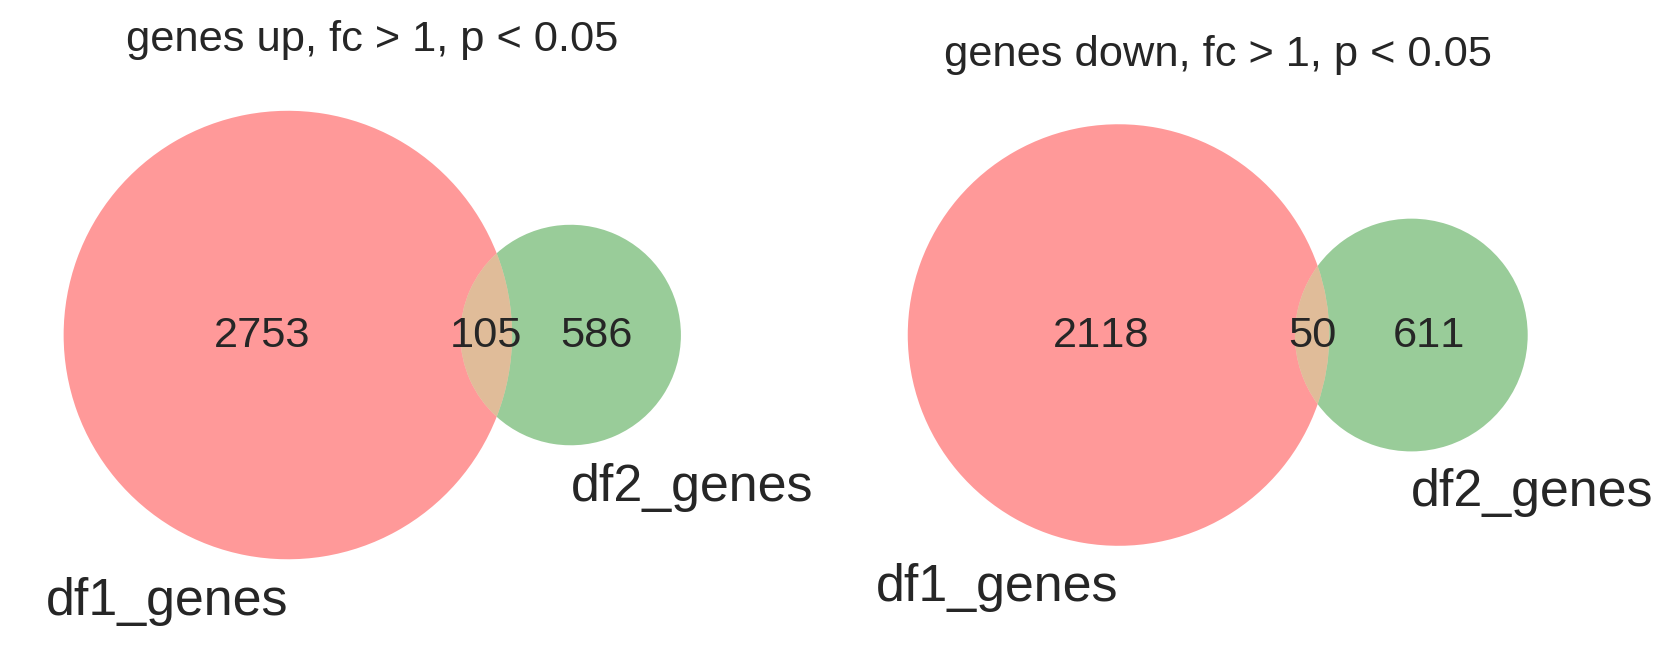

In [338]:
hypergeo_p, overlap = get_diff_hypergeom_test(lxrdko, flavo_diff, pval = 0.05, fc=0)

working on up genes
total genes: 24537
df sig genes: 534
df2 sig genes: 738
overlap: 88
hypergeometric p value: 9.85494365841e-40
working on down genes
total genes: 24537
df sig genes: 89
df2 sig genes: 741
overlap: 8
hypergeometric p value: 0.00401740736836


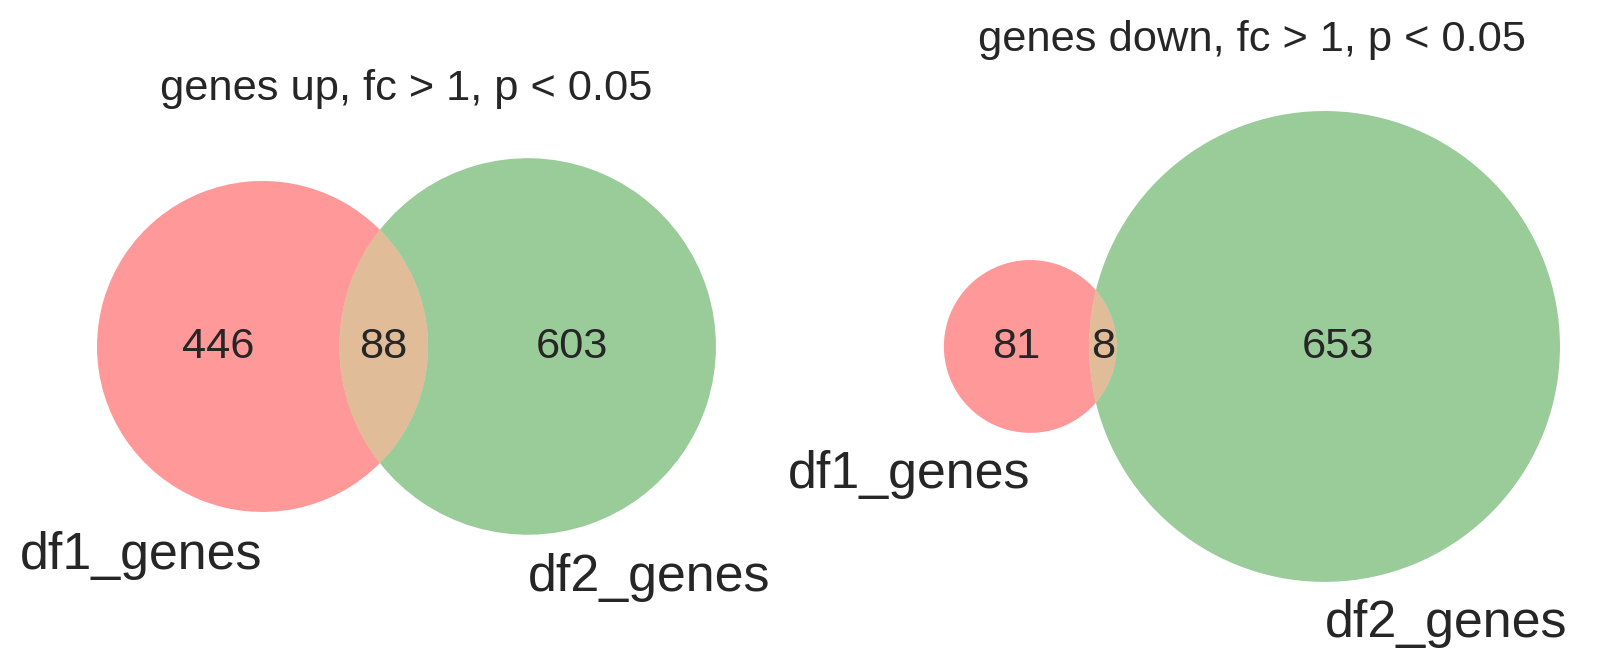

In [339]:
hypergeo_p, overlap = get_diff_hypergeom_test(dump, flavo_diff, pval = 0.05, fc=0)

It seems like there is some decent overlap between the flavopiridol effect and the samples we see as upregulated in our data. will compare this to the diff genes from when we replicate...

## test overlap between ido amit's kc gene signature and the lxrdko vs. lysm lxr dko

working on up genes
total genes: 24537
df sig genes: 639
input list sig genes: 303
overlap: 31
hypergeometric p value: 8.0957002646e-11
working on down genes
total genes: 24537
df sig genes: 637
input list sig genes: 303
overlap: 24
hypergeometric p value: 1.06490236046e-06


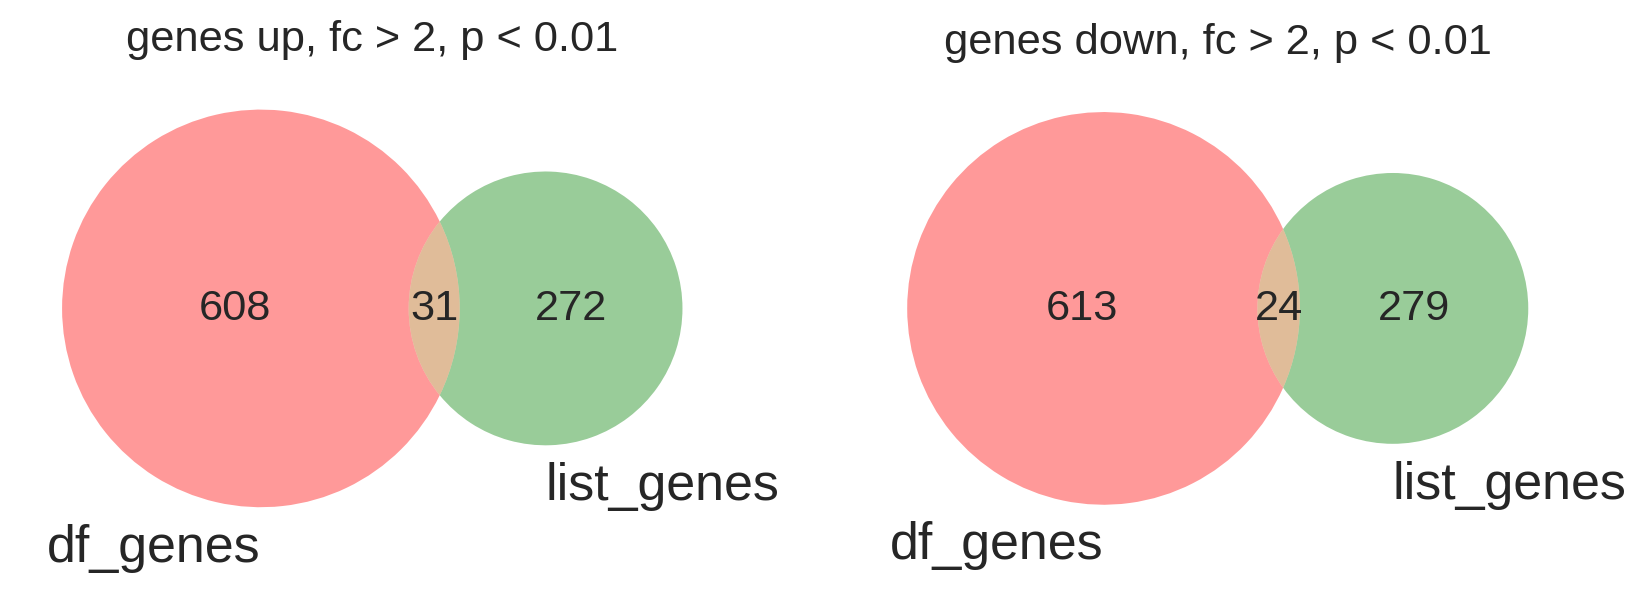

In [340]:
hypergeo_p, overlap = get_diff_hypergeom_test_list(lysm_dko, kc_amit, pval=0.01, fc=1)

In [341]:
overlap[1]

{'2810025M15Rik',
 'Aif1',
 'Apoc1',
 'Armc7',
 'Btbd11',
 'C6',
 'Cbr1',
 'Ccl24',
 'Cd207',
 'Cd59a',
 'Cd5l',
 'Clec1b',
 'Ctla2b',
 'Dhrs1',
 'Ephx1',
 'Fabp7',
 'Gngt2',
 'Grap',
 'Icos',
 'Il18bp',
 'Mafb',
 'Nudt16',
 'Tcf7l1',
 'Tmem37'}

While the LysMCre mice have significant overlap in their downregulated genes with the kc signature genes from ido amit, only a few of these genes appear to be "classic" kc genes - C6, Cd5l, however these are all also down the lxrdko mouse.

working on up genes
total genes: 24537
df sig genes: 1972
input list sig genes: 303
overlap: 48
hypergeometric p value: 2.56721738401e-06
working on down genes
total genes: 24537
df sig genes: 776
input list sig genes: 303
overlap: 60
hypergeometric p value: 1.29638857607e-30


{'Abcc3',
 'Adcy4',
 'Apoc1',
 'Arrb2',
 'Btbd11',
 'C6',
 'Ccl24',
 'Cd163',
 'Cd300ld',
 'Cd5l',
 'Cd86',
 'Cdh5',
 'Chp2',
 'Clec1b',
 'Clec4f',
 'Ctla2b',
 'Ctnnd1',
 'Ddx60',
 'Dhrs1',
 'Dmpk',
 'Dmwd',
 'Dram2',
 'Ephx1',
 'Fabp7',
 'Folr2',
 'Frmd4b',
 'Gbp8',
 'Gm4951',
 'Grap',
 'Hbegf',
 'Hpgd',
 'Icos',
 'Il18bp',
 'Klrk1',
 'Mafb',
 'Nudt16',
 'Oasl1',
 'Oplah',
 'P4ha1',
 'Plod1',
 'Ptgs1',
 'Rasgef1b',
 'Rbfox3',
 'Rgl1',
 'Slc25a33',
 'Slc40a1',
 'Snta1',
 'Tbc1d1',
 'Tbc1d2b',
 'Tmem268',
 'Trim30a',
 'Trpm2',
 'Usp12',
 'Vsig4',
 'Wdfy3',
 'Wdr60',
 'Zdhhc14',
 'Zfp532',
 'Zfp90',
 'Zswim6'}

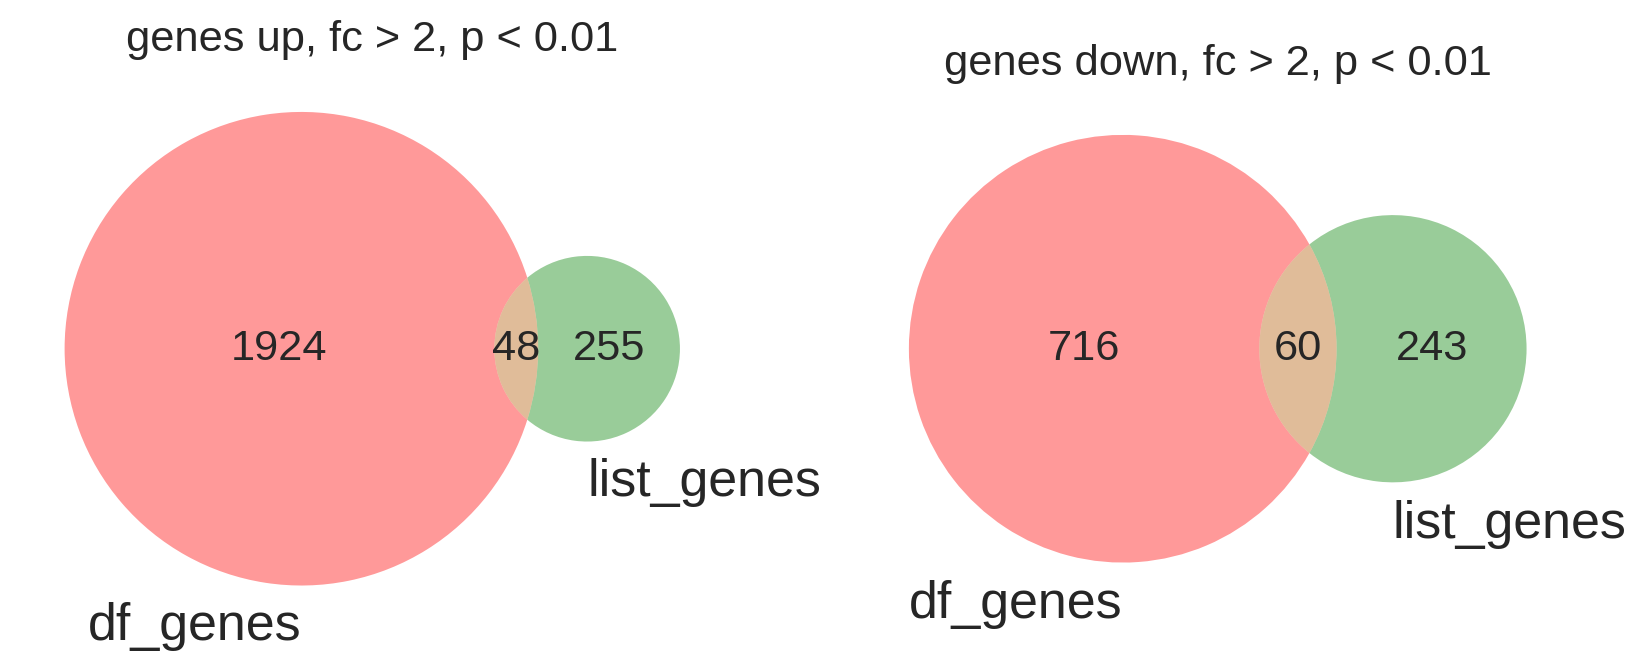

In [342]:
hypergeo_p, overlap = get_diff_hypergeom_test_list(lxrdko, kc_amit, pval=0.01, fc=1)
overlap[1]

working on up genes
total genes: 24537
df sig genes: 472
input list sig genes: 303
overlap: 26
hypergeometric p value: 1.99049591838e-10
working on down genes
total genes: 24537
df sig genes: 1642
input list sig genes: 303
overlap: 36
hypergeometric p value: 0.000300804158812


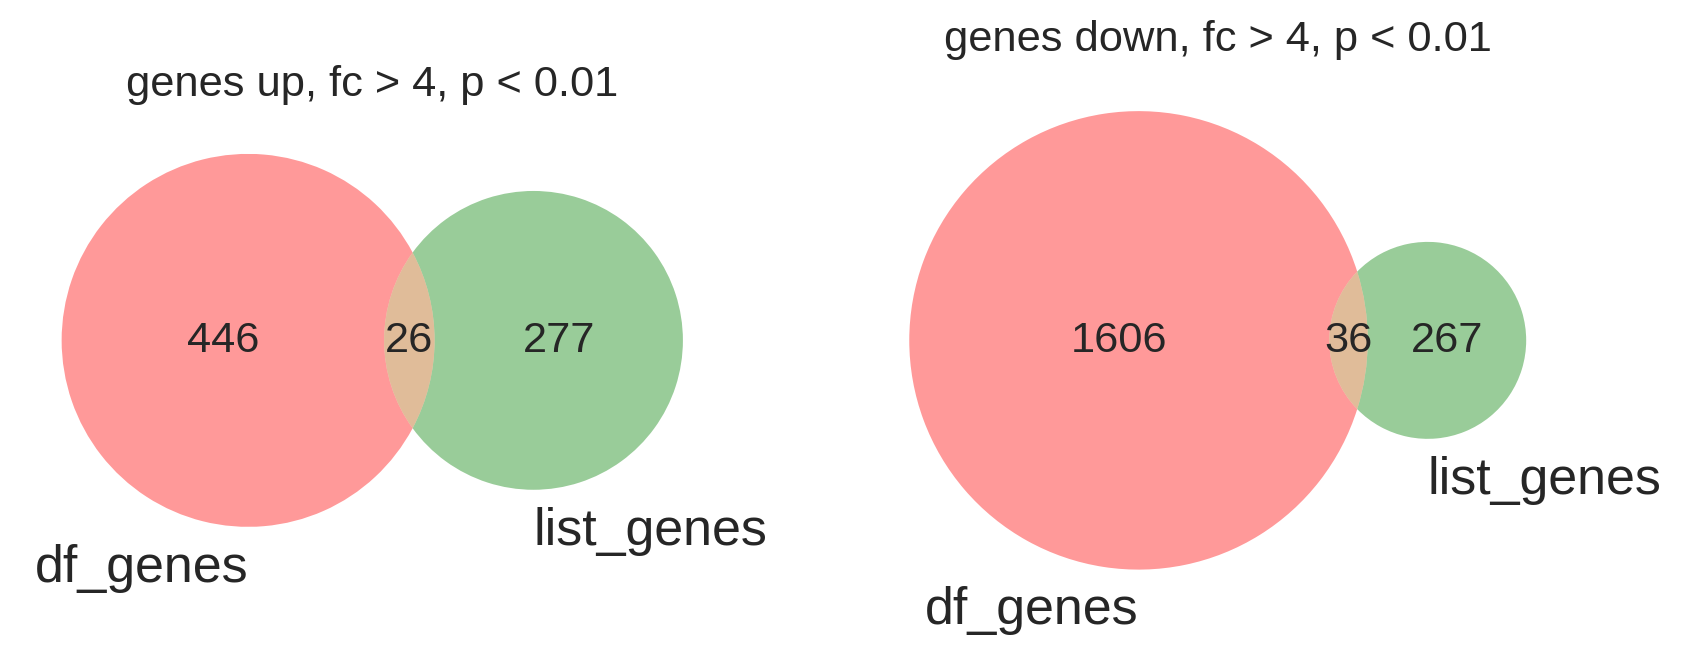

In [343]:
hypergeo_p, overlap = get_diff_hypergeom_test_list(lxrdko_lysmdko, kc_amit, pval=0.01, fc=2)

## Look at overlap between Scott 2018 Clec4f-Cre x LXRa fl/fl mouse

working on up genes
total genes: 24537
df sig genes: 639
input list sig genes: 248
overlap: 41
hypergeometric p value: 2.41766993238e-21
working on down genes
total genes: 24537
df sig genes: 637
input list sig genes: 248
overlap: 7
hypergeometric p value: 0.148272350888


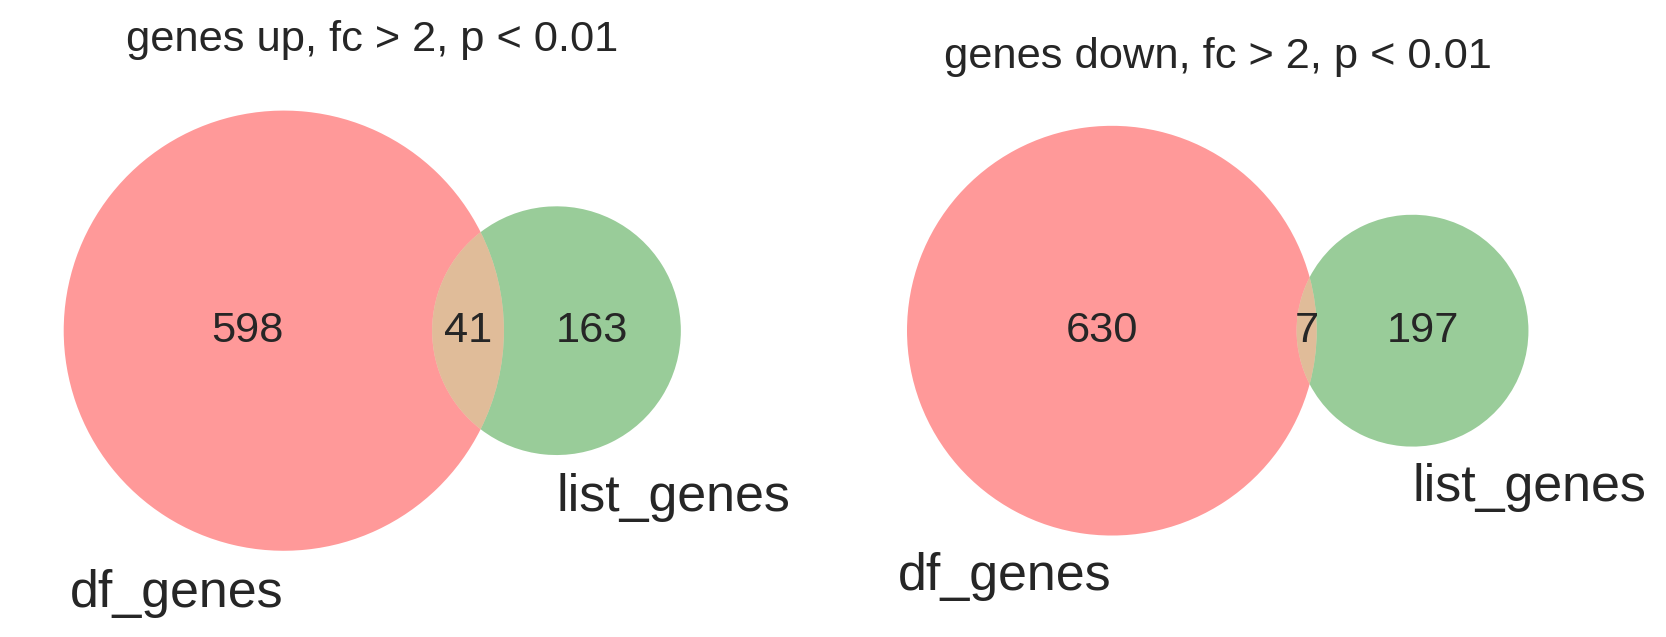

In [344]:
hypergeo_p, overlap = get_diff_hypergeom_test_list(lysm_dko,
                                                   scott_clec_lxrko_up,
                                                   pval=0.01,
                                                   fc=1)

working on up genes
total genes: 24537
df sig genes: 639
input list sig genes: 248
overlap: 9
hypergeometric p value: 0.0850158434749
working on down genes
total genes: 24537
df sig genes: 637
input list sig genes: 248
overlap: 45
hypergeometric p value: 4.2568304685e-25


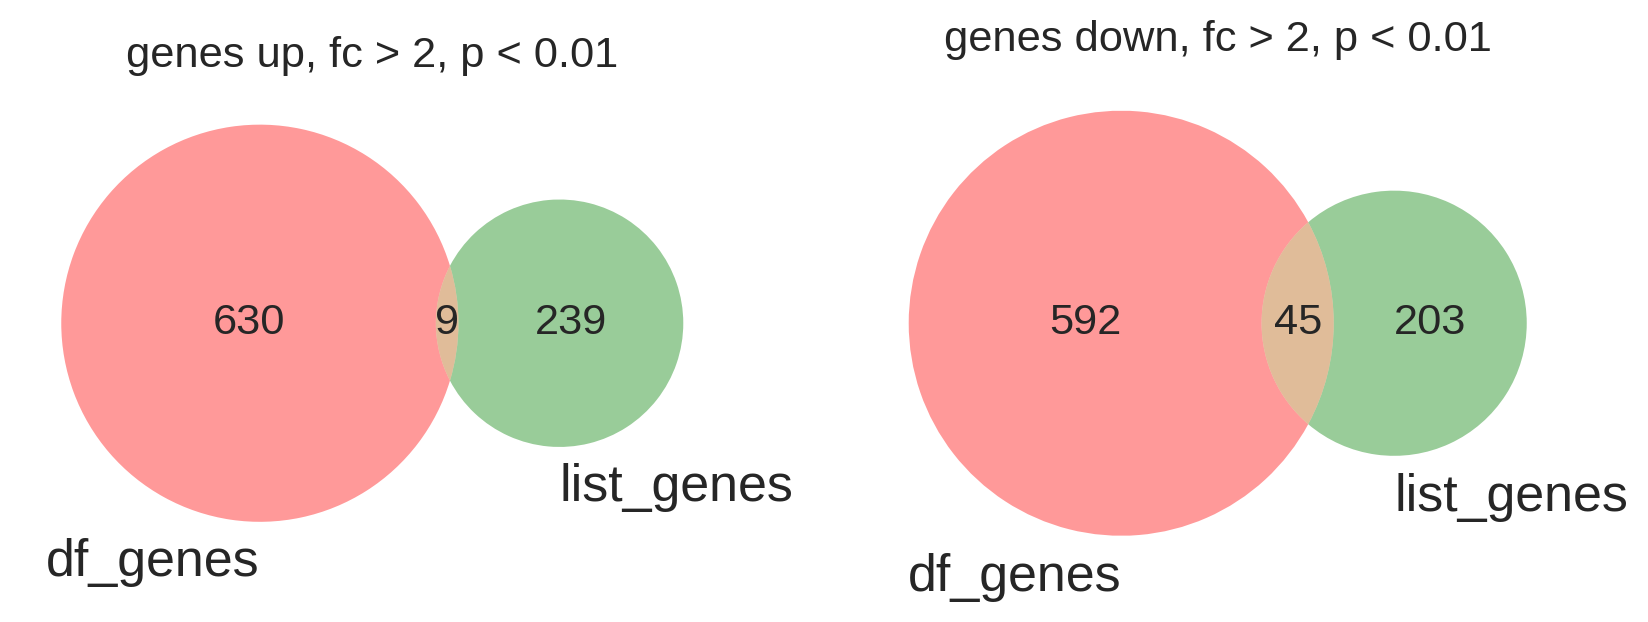

In [348]:
hypergeo_p, overlap = get_diff_hypergeom_test_list(lysm_dko,
                                                   scott_clec_lxrko_dn,
                                                   pval=0.01,
                                                   fc=1)

working on up genes
total genes: 24537
df sig genes: 1972
input list sig genes: 248
overlap: 40
hypergeometric p value: 1.02818946811e-05
working on down genes
total genes: 24537
df sig genes: 776
input list sig genes: 248
overlap: 1
hypergeometric p value: 0.00271573263536


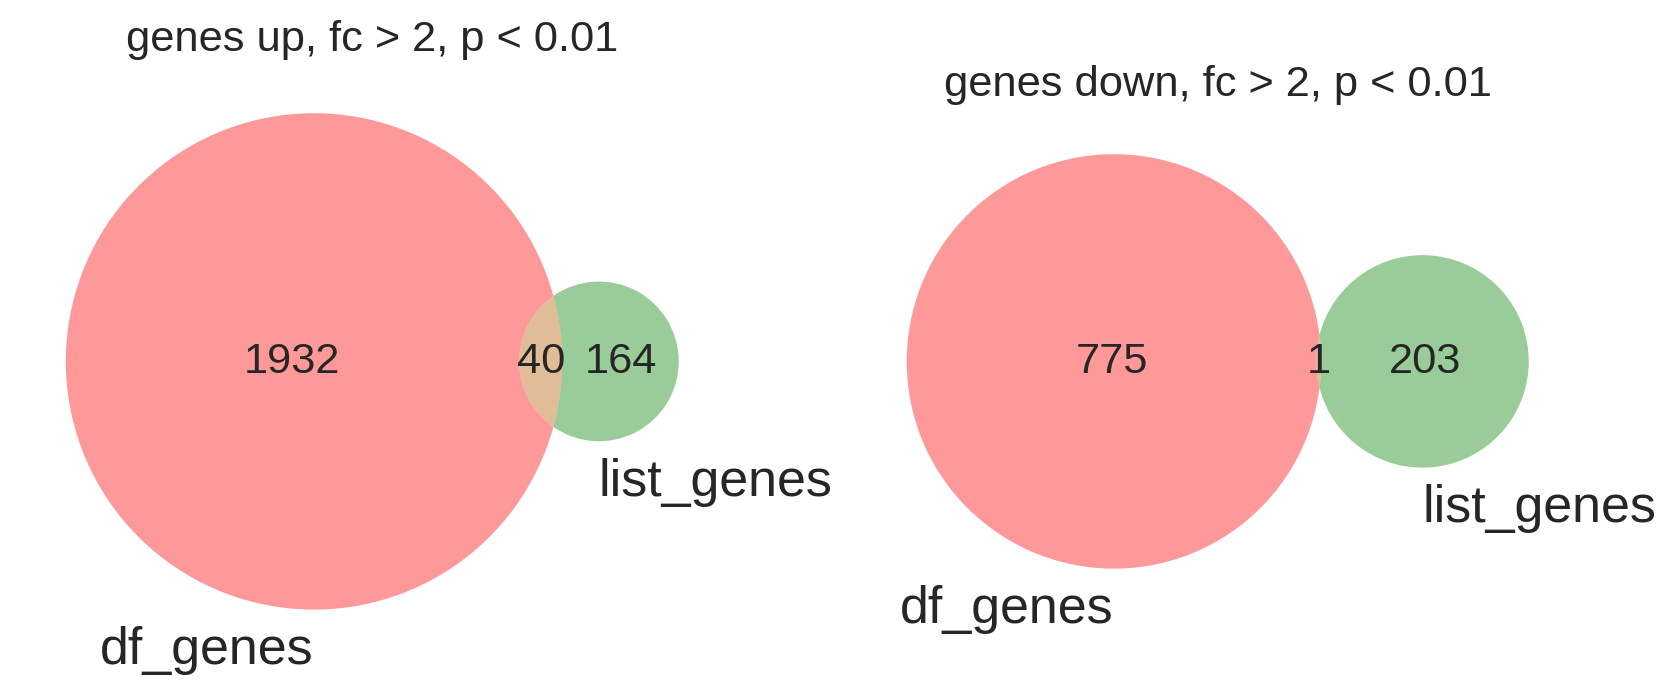

In [346]:
hypergeo_p, overlap = get_diff_hypergeom_test_list(lxrdko,
                                                   scott_clec_lxrko_up,
                                                   pval=0.01,
                                                   fc=1)

working on up genes
total genes: 24537
df sig genes: 1972
input list sig genes: 248
overlap: 1
hypergeometric p value: 1.85880460039e-08
working on down genes
total genes: 24537
df sig genes: 776
input list sig genes: 248
overlap: 140
hypergeometric p value: 3.94463190781e-145


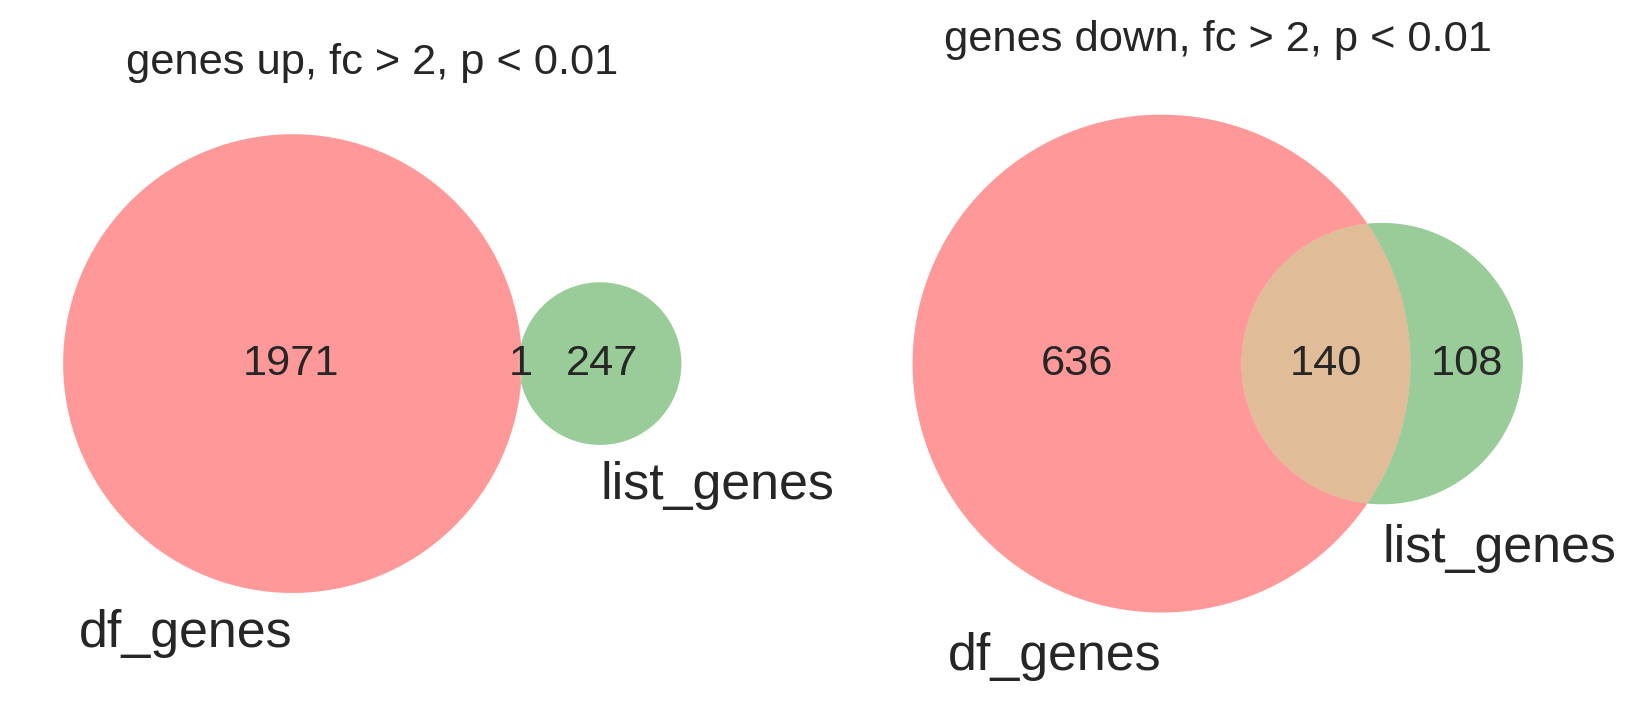

In [347]:
hypergeo_p, overlap = get_diff_hypergeom_test_list(lxrdko,
                                                   scott_clec_lxrko_dn,
                                                   pval=0.01,
                                                   fc=1)

It seems like the downregulated lxrdko genes match well with the scott lxrako down genes. also the lysm seem to match well but not much better than the lxrdko which is surprising because the lysm should be a little more similar since hepatocytes will still be expressing LXR in them.